# Begin
## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyedflib 
import pandas as pd
import mne

## Dowload data set 

In [2]:
# !wget -r -N -c -np https://physionet.org/files/eegmmidb/1.0.0/

## Positioning of electrodes on the head

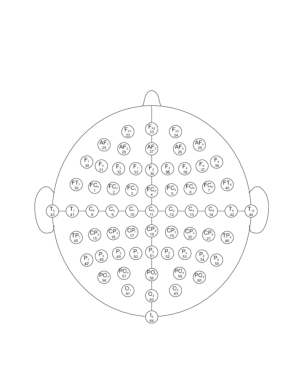

In [3]:
img = plt.imread('files/64_channel_sharbrough-old.png')
plt.imshow(img)
plt.axis('off')
plt.show()


# Convert from file to data frame

In [4]:
def file_to_DataDrame(path):
    """
    This function takes in a file path and returns a dataframe with the data and the target values
    format:
        Fc5	        Fc3	        Fc1	        ...	Oz	        O2	        Iz	        target
    0	-0.000046	-0.000041	-0.000032	...	0.000040	0.000108	0.000055	T0
    1	-0.000054	-0.000048	-0.000034	...	0.000064	0.000114	0.000074	T0
    ...
    """

    reader = mne.io.read_raw_edf(path, preload=True)
    annotations = reader.annotations  # get the values of the annotations
    codes = annotations.description  # get the codes from the annotations

    df = pd.DataFrame(
        reader.get_data().T,
        columns=[channel.replace(".", "") for channel in reader.ch_names],
    )  # transpose the data to get the right shape
    df = df[~(df == 0).all(axis=1)]  # remove rows with all zeros
    timeArray = np.array(
        [round(x, 10) for x in np.arange(0, len(df) / 160, 0.00625)]
    )  # create an array of time values

    codeArray = []
    counter = 0
    for timeVal in timeArray:
        if (
            timeVal in annotations.onset
        ):  # if the time value is in the onset array, add the corresponding code to the codeArray
            counter += 1
        code_of_target = int(
            codes[counter - 1].replace("T", "")
        )  # convert T0 to 0, T1 to 1, etc
        codeArray.append(code_of_target)

    df["target"] = np.array(codeArray).T
    return df

In [5]:
subject = 1
file = 5
fileName = f"files/S{subject:03d}/S{subject:03d}R{file:02d}.edf"

df = file_to_DataDrame(fileName)

Extracting EDF parameters from /home/daniel/repos/Decoding_of_EEG/files/S001/S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [6]:
df.head(2)

,Fc5,Fc3,Fc1,Fcz,Fc2,Fc4,Fc6,C5,C3,C1,...,Po7,Po3,Poz,Po4,Po8,O1,Oz,O2,Iz,target
0,-0.00001,0.00002,0.000007,-0.000018,0.000000,0.000004,0.000060,0.000004,0.000012,0.000006,...,0.000030,0.000025,0.000022,0.000013,-0.000009,0.00002,0.000024,0.000089,0.000068,0
1,0.00001,0.00005,0.000049,0.000022,0.000038,0.000031,0.000084,0.000025,0.000043,0.000049,...,0.000044,0.000031,0.000027,0.000025,0.000012,0.00003,0.000025,0.000083,0.000065,0


In [7]:
df.tail(2)

,Fc5,Fc3,Fc1,Fcz,Fc2,Fc4,Fc6,C5,C3,C1,...,Po7,Po3,Poz,Po4,Po8,O1,Oz,O2,Iz,target
19918,-0.000024,-0.000005,-0.00002,-0.000017,-0.000021,-0.000025,-0.000039,0.000001,-0.000011,-0.000012,...,-0.000030,-0.000015,0.000001,0.000019,0.000033,0.000001,0.000016,0.000026,0.000002,1
19919,-0.000032,-0.000029,-0.00004,-0.000027,-0.000030,-0.000031,-0.000049,-0.000015,-0.000027,-0.000027,...,-0.000004,0.000008,0.000018,0.000035,0.000048,-0.000019,0.000002,0.000011,-0.000015,1


In [8]:
def index_of_TX(df):
    key = 0
    dict_TX_index = {key: [df['target'][0], 0] }
    current_TX = df['target'][0]
    for i in range(len(df['target'])):
        if df['target'][i] != current_TX:
            key += 1
            dict_TX_index[key] = [df['target'][i], i]
            current_TX = df['target'][i]
 
    return dict_TX_index
   
        
print(index_of_TX(df))

{0: [0, 0], 1: [2, 672], 2: [0, 1328], 3: [1, 2000], 4: [0, 2656], 5: [2, 3328], 6: [0, 3984], 7: [1, 4656], 8: [0, 5312], 9: [2, 5984], 10: [0, 6640], 11: [1, 7312], 12: [0, 7968], 13: [1, 8640], 14: [0, 9296], 15: [2, 9968], 16: [0, 10624], 17: [2, 11296], 18: [0, 11952], 19: [1, 12624], 20: [0, 13280], 21: [2, 13952], 22: [0, 14608], 23: [1, 15280], 24: [0, 15936], 25: [1, 16608], 26: [0, 17264], 27: [2, 17936], 28: [0, 18592], 29: [1, 19264]}


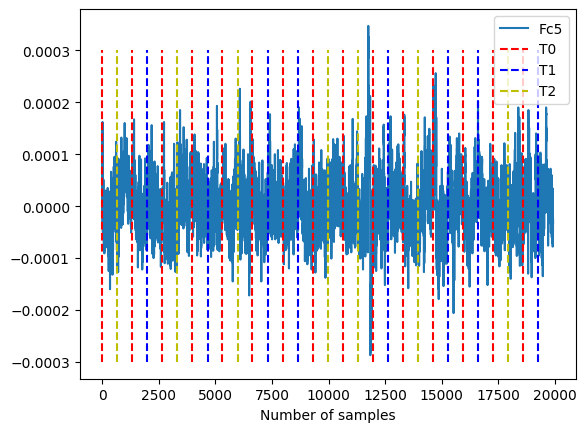

In [9]:
indexs = index_of_TX(df)
xT0=[]
xT1=[]
xT2=[]
ax= df.plot(y='Fc5')
ax.set_xlabel("Number of samples")
for i in range(0,len(indexs)):
    if indexs[i][0] == 0:
        xT0.append(indexs[i][1])      
    elif indexs[i][0] == 1:
        xT1.append(indexs[i][1])
    elif indexs[i][0] == 2:
        xT2.append(indexs[i][1])
#doter line
ax.vlines(x=xT0, ymin=-0.0003, ymax=0.0003, color='r',label='T0',linestyles='dashed')
ax.vlines(x=xT1, ymin=-0.0003, ymax=0.0003, color='b',label='T1',linestyles='dashed')
ax.vlines(x=xT2, ymin=-0.0003, ymax=0.0003, color='y',label='T2', linestyles='dashed')
ax.legend()



# Colect data in one data set

In [10]:
def all_exp_to_array(num_person, choose_num_of_exp):
    """
    num_person: int renage(1,109)
    choose_num_of_exp: list of int[3,4,7,8,11,12]

    return: all_meseurments, all_targets
    """
   

    all_meseurments = np.zeros((len(choose_num_of_exp),20000,64))
    all_targets = np.zeros((len(choose_num_of_exp),20000))
    for i in range(len(choose_num_of_exp)):
        fileName = f"files/S{num_person:03d}/S{num_person:03d}R{choose_num_of_exp[i]:02d}.edf"
        df = file_to_DataDrame(fileName)
        for j in range(20000):
            if j >= len(df):
                all_meseurments[i][j] = np.zeros(64) 
                all_targets[i][j] = np.nan
            else:
                all_meseurments[i][j] = df.iloc[j].values[:-1]
                all_targets[i][j] = df.iloc[j].values[-1]
    return all_meseurments, all_targets
                
      
          

In [11]:
def all_files_to_array(choose_num_of_exp):
    """
    num_person: int 
    choose_num_of_exp: list of int [3,4,7,8,11,12]

    return: all_meseurments, all_targets
    """
    all_meseurments = np.zeros((109,len(choose_num_of_exp),20000,64))
    all_targets = np.zeros((109,len(choose_num_of_exp),20000))
    for i in range(1, 109):
        all_meseurments[i], all_targets[i] = all_exp_to_array(i, choose_num_of_exp)
    return all_meseurments, all_targets

In [ ]:
all_meseurments, all_targets = all_files_to_array([3,4,7,8,11,12])